<a href="https://colab.research.google.com/github/TomGervers/arXiv_astro_ML/blob/main/arXiv_exploration_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General imports

In [2]:
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re
from ast import literal_eval

# Download and prepare the dataset

###Use the following if you want to download the latest version of the dataset.

Install the Kaggle api.

In [ ]:
!pip install -q kaggle

This will prompt the user to upload a file. The file uploaded should be the kaggle.json file containing information about their Kaggle API key, this is available under the API heading at: https://www.kaggle.com/settings/account

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tomgeeee","key":"9b00fb8914de3d63b6eb34bbfbd21ce5"}'}

Remove if exists and then create a Kaggle folder which the kaggle.json file is then moved to.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Download the arXiv dataset from Kaggle.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

100% 1.18G/1.18G [00:47<00:00, 27.3MB/s]
100% 1.18G/1.18G [00:48<00:00, 26.4MB/s]


Remove if exists and then create a dataset folder which the arXiv dataset is unzipped into.

In [ ]:
!rm -r dataset
!mkdir dataset

!unzip arxiv.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
Archive:  arxiv.zip
  inflating: dataset/arxiv-metadata-oai-snapshot.json  


###Use these steps if you have a version of the dataset downloaded you wish to upload and use.

Prompt to upload the file.

In [ ]:
from google.colab import files
files.upload()

The file should be uploaded as "arxiv.zip".

In [ ]:
!rm -r dataset
!mkdir dataset

!unzip arxiv.zip -d dataset

###Use these steps if you have already run part (or all) of this notebook already and have a "papers_df.csv" you wish to resume from.

####Manual upload method

Prompt to upload the file.

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

####Google Drive import method

Alternative method to upload by copying from Google drive (this can be faster). Filepath will need to be changed to where you have the file saved.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/y4_final/papers_df.csv /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Convert to dataframe

Read in the paper as pandas dataframe.

In [6]:
papers_df = pd.read_csv('papers_df.csv',index_col=0, converters={'categories_list': literal_eval, 'clean_authors': literal_eval}, parse_dates=['created_datetime'])

<ipython-input-6-ccc4bf191523>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  papers_df = pd.read_csv('papers_df.csv',index_col=0, converters={'categories_list': literal_eval, 'clean_authors': literal_eval}, parse_dates=['created_datetime'])


# Read the dataset, extracting any papers categorised with any astrophysics tags

**Only run this section if you did not upload a papers_df.csv file previously.**

Defining the arXiv astro-ph categories.

In [ ]:
category_ids = ['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR']

Defining a function that splits the string containing the authors names into a list of authors.

In [ ]:
def get_clean_authors(authors):
    r = []
    for a in authors:
        r.append(" ".join(a).strip())
    return r

Reading the dataset JSON and processing it, extracting the information desired on each line and returning it as a pandas dataframe.

In [ ]:
cols = ['id', 'clean_authors', 'title', 'abstract', 'versions', 'categories_list'] #Define dataframe column names
papers = [] #Create empty list for storing papers information in

with open("dataset/arxiv-metadata-oai-snapshot.json", "r") as f: #Open the dataset json file
    for l in f: #For each line in the file
        d = json.loads(l) #Load the line with json
        if any(x in category_ids for x in d['categories'].split(' ')): #Read the list of categories and split it, compare the new list to the list of astro-ph categories
            d['clean_authors'] = get_clean_authors(d['authors_parsed']) #Use get_clean_authors to convert the string of authors into a list
            list = [d['id'], d['clean_authors'], d['title'], d['abstract'], d['versions'], d['categories'].split(' ')] #Extract the desired columns and add to a new list
            papers.append(list) #Append the new list to the list of papers

papers_df = pd.DataFrame().from_records(papers, columns=cols) #Create a dataframe from the lists, papers, and columns
#Take the first entry in the versions list and convert to datetime
papers_df['created_datetime'] = [datetime.datetime.strptime(date[0]['created'].split(',')[1],' %d %b %Y %H:%M:%S %Z') for date in papers_df['versions']]
papers_df['year'] = papers_df['created_datetime'].dt.year #Convert the datetime to just the year

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Extract papers which involve machine learning

Remove newline (\n) characters from the papers abstracts.

In [ ]:
papers_df[['abstract']] = papers_df[['abstract']].replace(r'\n',' ', regex=True) #Replace all newline characters in the abstract with empty space

Save the dataframe containing the papers as a CSV file if desired.

In [ ]:
papers_df.to_csv("papers_df.csv") #Save to a csv file

Define the words/phrases for each wave and the overall list

In [ ]:
wave1 = ['perceptron', 'multilayer perceptron', 'multi-layer perceptron', 'multi layer perceptron', 'artificial neuron', 'artificial neural network', 'artificial neural', 'artificial neural-network', 'backpropagation',
         'artificial neural net', 'artificial-neural net', 'artificial neural-net', 'artificial-neural-net', 'Neural Network', 'Neural-Network', 'Neural-Net', 'Neural Net']
wave2 = ['Convolutional Neural', 'convolutional neural network', 'convolutional neural-network', 'Recurrent Neural', 'Recurrent neural network', 'Recurrent neural-network', 'convolutional layer', 'pooling layer',
         'LSTM', 'long short-term memory', 'long short term memory', 'long short-term', 'long short term', 'gated recurrent', 'gated-recurrent', 'residual network', 'transformer',' transformers', 'transformer model',
         'self-attention', 'self attention', 'supervised learning', 'supervised deep learning', 'supervised deep-learning']
wave3 = ['deep generative modelling', 'deep generative-modelling', 'deep generative', 'generative modelling', 'generative', 'GAN', 'generative adversarial', 'autoencoder', 'auto-encoder', 'variational autoencoder',
         'variational auto-encoder', 'score-based model', 'score based model', 'score-based  generative model', 'score based generative model', 'competing neural', 'competing neural-networks',
         'representation learning', 'self-supervised', 'self supervised', 'contrastive learning', 'learning representations', 'surrogate task', 'word embedding', 'word-embedding']
phrases = ['Artificial Intelligence', 'Machine Learning','LLMS','Large Language Models', 'support vector machine', 'support vector', 'deep learning', 'deep-learning']

Defining the regex search function that searches each abstract for the phrases in the list.

In [ ]:
def contains_phrase(row,phrases):
    for phrase in phrases: #Repeat for each word in the list
        if re.search(r'\b' + phrase + r'\b', row, re.IGNORECASE): #Search phrase surrounded by word breaks, ignoring case
            return True
    return False

Extract the papers that contain the search phrases

In [ ]:
wave1_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave1,))] #Get papers for wave1
wave2_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave2,))] #Get papers for wave2
wave3_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(wave3,))] #Get papers for wave3
phrases_temp_df = papers_df[papers_df['abstract'].apply(contains_phrase, args=(phrases,))] #Get general papers

frames = [wave1_df, wave2_df, wave3_df, phrases_temp_df]
phrases_df = pd.concat(frames) #Combine the prior dfs into one
phrases_df.drop_duplicates(subset=['id'],inplace=True) #Drop any duplicates based on the id number

# Using TF-IDF and a Support Vector Machine to attempt to classify papers

###Preprocessing steps

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

Download English language stopwords from nltk and add to a set.

In [ ]:
nltk.download('punkt') #Donwload the punkt sentence tokenizer
nltk.download('stopwords') #Download the corpus of stopwords
stop_words = set(stopwords.words('english')) #Make a set of English stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Define a function for preprocessing the abstract strings.

In [ ]:
def preprocessing(line):
    line = line.lower() #Convert to lowercase
    line = re.sub(r'\b\w{1,3}\b', '', line) #Remove any words less than 4 characters long
    line = re.sub(r"[{}]".format(string.punctuation), " ", line) #Remove all punctuation
    line = line.replace('\\', '') #Remove leftover backslashes
    line = line.translate({ord(k): None for k in string.digits}) #Remove all digits
    line = " ".join([i for i in word_tokenize(line) if i not in stop_words]) #Remove all stopwords
    return line

###Creating the training and test datasets

In [ ]:
from sklearn.model_selection import train_test_split

Define new dataframes consisting of only papers that the regex search did not classify as using machine learning and papers which were identified as using ML byt not part of any wave.

In [ ]:
non_ml_df = pd.concat([papers_df, phrases_df, phrases_df]).drop_duplicates(subset=['id'], keep=False)
non_wave_df = pd.concat([phrases_temp_df, wave1_df, wave1_df, wave2_df, wave2_df, wave3_df, wave3_df]).drop_duplicates(subset=['id'], keep=False)

Create the training and test sets.

In [ ]:
whole_df_mc = pd.concat([wave1_df.sample(340), wave2_df.sample(340), wave3_df.sample(340), non_wave_df.sample(340), non_ml_df.sample(5440)]) #Create an overall of 1000 ML (positive) examples and 4000 non-ml (negative) examples

whole_df_mc['target'] = ((['Wave1']*340) + (['Wave2']*340) + (['Wave3']*340) + (['Non-Wave']*340)+ (['Non-ML']*5440)) #Add the corresponding labels as a new column

whole_df_mc.drop_duplicates(subset=['id'],inplace=True)

#Create new dataframes to hold the training and test sets
whole_train_mc = pd.DataFrame()
whole_test_mc = pd.DataFrame()

#Split the data into train and test sets with a ratio of 0.8/0.2, split is stratified based on the target label
whole_train_mc['data'], whole_test_mc['data'], whole_train_mc['target'], whole_test_mc['target'] = train_test_split(whole_df_mc['abstract'],
                                                                                                        whole_df_mc['target'], stratify=whole_df_mc['target'],
                                                                                                        test_size=0.2, random_state=42)

#Redefine whole_df to save memory
whole_df_mc = ''

Using the preprocessing on the training and test sets.

In [ ]:
processed = [] #Create empty list to store strings

for df in [whole_train_mc, whole_test_mc]: #For each dataframe
    for i,a in df.iterrows(): #Iterate over each row
        processed.append(preprocessing(a['data'])) #Append the preprocessed abstract string to the list
    df['data'] = processed #Replace the data column with the preprocessed data

    processed = [] #Reset the list

###Converting data to TF-IDF, fitting the classifier and testing it.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

Create a scikit-learn pipeline that implements a count vectorizer, a TF-IDF transformer, and a linear SVM classifier with automatically balanced class weights.

In [ ]:
text_clf_BSVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear', class_weight='balanced')),
])

Fit the SVM to the training data by running it through the pipeline so it uses the TFIDF data.

In [ ]:
text_clf_BSVM.fit(whole_train_mc.data, whole_train_mc.target) #Fit the classifier

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(class_weight='balanced', kernel='linear'))])

Use the SVM classifier to make predictions for the labels of the test data.

In [ ]:
preds_mc = text_clf_BSVM.predict(whole_test_mc.data) #Make predictions on the test data

Create and plot the confusion matrix of the results of the test set. classification.

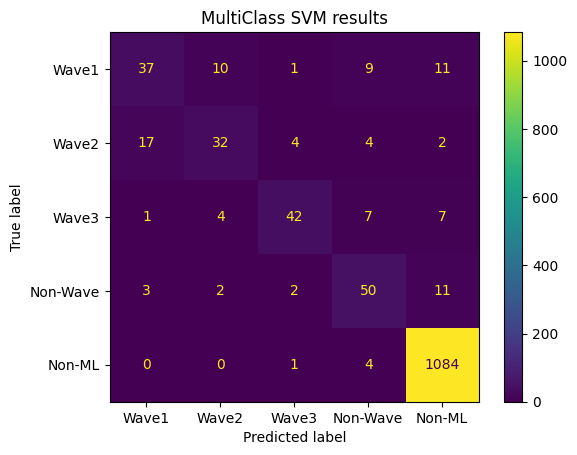

In [ ]:
cm = confusion_matrix(whole_test_mc.target, preds_mc, labels=['Wave1', 'Wave2', 'Wave3', 'Non-Wave', 'Non-ML']) #Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Wave1', 'Wave2', 'Wave3', 'Non-Wave', 'Non-ML']) #Display confusion matrix
disp.plot()
plt.title('MultiClass SVM results') #Set the plot title
plt.show() #Show the plot

Find the false positive and negative examples and calculate accuracy. This is only based off the labels from the regex search and in practice many of the false positive or negative predictions are actually correctly identified by the SVM and the original labels were wrong.

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm) #Calculate FP
FN = cm.sum(axis=1) - np.diag(cm) #Calculate FN
TP = np.diag(cm) #Calculate TP
TN = cm.sum() - (FP + FN + TP) #Calculate TN
ACC = (TP+TN)/(TP+FP+FN+TN) #Calculate overall accuracy

print('Wave 1 1:{} \nWave 2:{} \nWave 3:{} \nNon-Wave:{} \nNon-ML:{}'.format(round(ACC[0],3),round(ACC[1],3),round(ACC[2],3),round(ACC[3],3),round(ACC[4],3))) #Print the accuracy for each label

Wave 1 1:0.961 
Wave 2:0.968 
Wave 3:0.98 
Non-Wave:0.969 
Non-ML:0.973


###Use grid search to find the best parameters. The default set values previously were found to have the best results in testing.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
BSVM_params = {
    'clf__class_weight':['balanced'],
    'clf__C':np.linspace(1, 10, 10),
    'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
} #Define the parameters to be searched in the classifier

gs_clf = GridSearchCV(text_clf_BSVM, BSVM_params, cv=5, n_jobs=-1) #Create the grid search object with number of cores used set to most available
gs_clf = gs_clf.fit(whole_test_mc.data[:400], whole_test_mc.target[:400]) #Test with each parameter combination on a subset of the test set

gs_clf.best_score_
for param_name in sorted(BSVM_params.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name])) #Print the best found parameters

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 186, in fit
    raise TypeError("Sparse precomputed kernels are not supported.")
TypeError:

clf__C: 2.0
clf__class_weight: 'balanced'
clf__kernel: 'sigmoid'


###Making predictions on the full dataset

Applying the preprocessing function to all abstracts in the papers dataframe.

In [ ]:
preprocessed = []

for i,a in papers_df.iterrows():
        preprocessed.append(preprocessing(a.abstract))

papers_df['preprocessed'] = preprocessed
preprocessed = ''

Using the SVM to predict the labels for the preprocessed abstracts and adding into seperate dataframes for each label.

In [ ]:
papers_df['predicted'] = text_clf_BSVM.predict(papers_df.preprocessed)

svm_wave1_df = papers_df.loc[papers_df['predicted']=='Wave1']
svm_wave2_df = papers_df.loc[papers_df['predicted']=='Wave2']
svm_wave3_df = papers_df.loc[papers_df['predicted']=='Wave3']
svm_nonwave_df = papers_df.loc[papers_df['predicted']=='Non-Wave']

Concatenating the seperate dataframes into one combined dataframe.

In [ ]:
svm_full_df = pd.concat([svm_wave1_df, svm_wave2_df, svm_wave3_df, svm_nonwave_df])

In [ ]:
svm_full_df.to_csv('svm_full_df.csv')

# Hypothesis testing

In [2]:
svm_full_df = pd.read_csv('svm_full_df.csv',index_col=0, converters={'categories_list': literal_eval, 'clean_authors': literal_eval}, parse_dates=['created_datetime'])

In [3]:
svm_full_22_df = svm_full_df.loc[svm_full_df['year'] != 2023]

In [7]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.linewidth'] = 1.5

###Hypothesis 1

Import scipy's curve_fit function and define a function for the general form of an exponential function.

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

Define the data to be used in fitting the curve, this is the data from 2005 to 2022.

In [ ]:
xdata = np.arange(0, 18, 1,dtype=int)
ydata = svm_full_22_df['year'].value_counts().sort_index().values[12:]

Use the curve_fit function to find the optimal constant parameters for the exponential function.

In [ ]:
popt, _ = curve_fit(func, xdata, ydata)

Define the x and y values for the exponential function curve, using the optimal constant parameters found.

In [ ]:
x = np.arange(0, 18, 1,dtype=int)

a=popt[0]
b=popt[1]
c=popt[2]

y = (a * (np.exp(b * x))) + c

Plot the paper number data and the exponential function on both a linear and logarithmic axis.

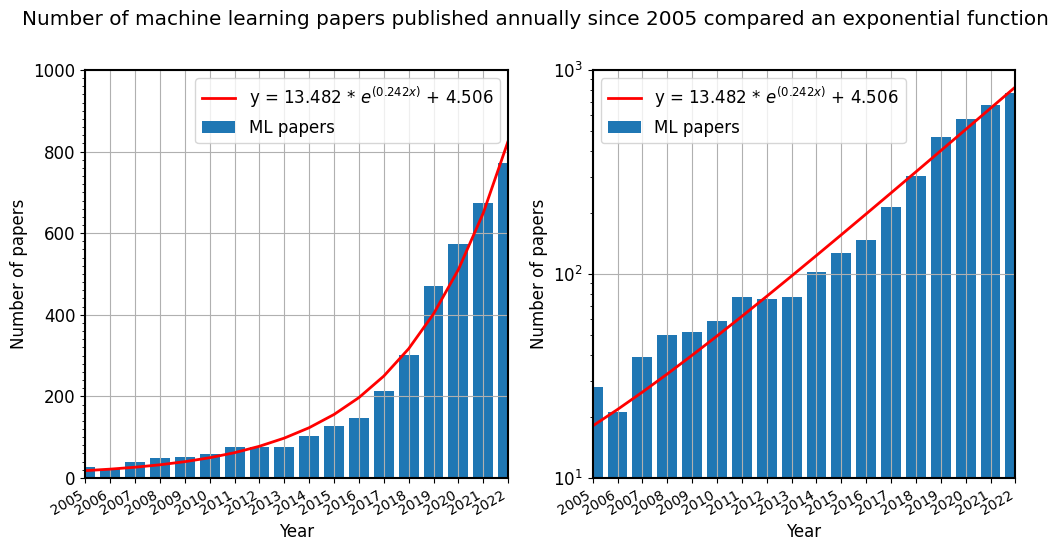

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (12,6))

axs[0].bar(svm_full_22_df['year'].value_counts().sort_index().index, svm_full_22_df['year'].value_counts().sort_index().values, label = 'ML papers')
axs[0].plot(x+2005, y, label = 'y = %5.3f * $e^{(%5.3fx)}$ + %5.3f' % tuple(popt), color ='r', linewidth=2)
axs[0].legend()
axs[0].set_ylim(0, 1000)
axs[0].set_xlim(2005, 2022)
axs[0].set_xticks(np.arange(2005, 2023, 1))
axs[0].tick_params(axis='x', which='major', labelsize=10)
axs[0].yaxis.set_minor_locator(MultipleLocator(20))
axs[0].set_ylabel('Number of papers')
axs[0].set_xlabel('Year')
axs[0].grid()

axs[1].bar(svm_full_22_df['year'].value_counts().sort_index().index, svm_full_22_df['year'].value_counts().sort_index().values, label = 'ML papers')
axs[1].plot(x+2005, y, label = 'y = %5.3f * $e^{(%5.3fx)}$ + %5.3f' % tuple(popt), color ='r', linewidth=2)
axs[1].legend()
axs[1].set_ylim(10, 1000)
axs[1].set_xlim(2005, 2022)
axs[1].set_xticks(np.arange(2005, 2023, 1))
axs[1].tick_params(axis='x', which='major', labelsize=10)
axs[1].yaxis.set_minor_locator(MultipleLocator(20))
axs[1].set_ylabel('Number of papers')
axs[1].set_xlabel('Year')
axs[1].grid()
axs[1].set_yscale('log', base=10)

fig.autofmt_xdate()
fig.suptitle('Number of machine learning papers published annually since 2005 compared an exponential function')

plt.savefig('hyp1.png')
plt.show()

In [ ]:
!pip install similaritymeasures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.7.0-py3-none-any.whl size=15451 sha256=b9732f9d99b597c4f474fbde128906788b452623f7c9fc142874873a29e78c72
  Stored in directory: /root/.cache/pip/wheels/24/a6/80/6f1676caf08ab1b69d74c8a727c96fdd3903d891672b415008
Successfully built similaritymeasures


In [ ]:
import similaritymeasures

In [ ]:
exp_data = np.zeros((18, 2))
exp_data[:, 0] = (x + 2005)
exp_data[:, 1] = y
num_data = np.zeros((18, 2))
num_data[:, 0] = svm_full_22_df['year'].value_counts().sort_index().index[12:]
num_data[:, 1] = svm_full_22_df['year'].value_counts().sort_index().values[12:]

In [ ]:
pcm = similaritymeasures.pcm(exp_data, num_data)
print(pcm)
area = similaritymeasures.area_between_two_curves(exp_data, num_data)
print(area)
mae = similaritymeasures.mae(exp_data, num_data)
print(mae)
# mean squared error
mse = similaritymeasures.mse(exp_data, num_data)
print(mse)

0.21907936936755346
432.2639960006636
12.90577218995657
530.552898702725


###Hypothesis 2

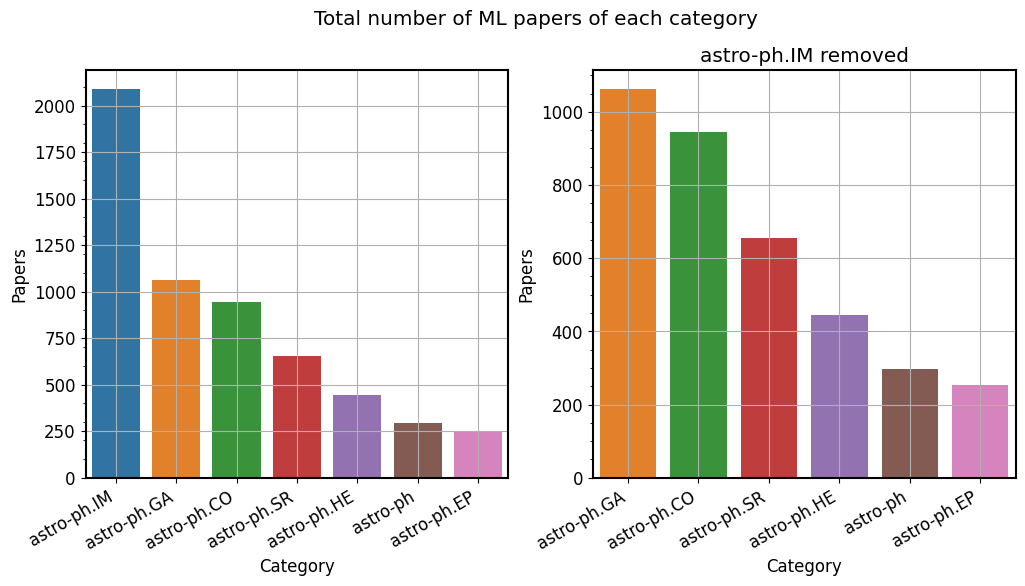

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))

svm_full_22_df_cats = svm_full_22_df.explode('categories_list')
svm_full_22_df_cats = svm_full_22_df_cats.loc[svm_full_22_df_cats['categories_list'].isin(category_ids)]

svm_full_22_df_cats_noim = svm_full_22_df_cats[svm_full_22_df_cats["categories_list"] != "astro-ph.IM"]

pal1 = (sns.color_palette())
pal2 = (sns.color_palette())[1:]

sns.barplot(x = svm_full_22_df_cats.categories_list.value_counts().index, y=svm_full_22_df_cats.categories_list.value_counts().values, ax=axs[0], palette=pal1)
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Papers')
axs[0].grid()
axs[0].yaxis.set_minor_locator(MultipleLocator(100))

sns.barplot(x = svm_full_22_df_cats_noim.categories_list.value_counts().index, y=svm_full_22_df_cats_noim.categories_list.value_counts().values, ax=axs[1], palette=pal2)
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Papers')
axs[1].set_title('astro-ph.IM removed')
axs[1].grid()
axs[1].yaxis.set_minor_locator(MultipleLocator(50))

fig.autofmt_xdate()
fig.suptitle('Total number of ML papers of each category')

plt.savefig('hyp2.png')
plt.show()

In [ ]:
svm_full_22_df_cats.categories_list.value_counts()

astro-ph.IM    2089
astro-ph.GA    1062
astro-ph.CO     945
astro-ph.SR     655
astro-ph.HE     444
astro-ph        296
astro-ph.EP     253
Name: categories_list, dtype: int64

In [ ]:
cat_df = pd.DataFrame(svm_full_22_df_cats.categories_list.value_counts())
cat_df_noim = pd.DataFrame(svm_full_22_df_cats_noim.categories_list.value_counts())

In [ ]:
years = svm_full_22_df.year.unique()
years.sort()

im_dict = {}
ga_dict = {}
co_dict = {}
sr_dict = {}
he_dict = {}
ep_dict = {}
ph_dict = {}

for j in years:
    temp_df = (svm_full_22_df.loc[svm_full_22_df['year'] == j]).explode('categories_list')
    for i in temp_df.categories_list:
        if i == 'astro-ph.IM':
            im_dict.setdefault(j, 0)
            im_dict[j] += 1
        elif i == 'astro-ph.GA':
            ga_dict.setdefault(j, 0)
            ga_dict[j] += 1
        elif i == 'astro-ph.CO':
            co_dict.setdefault(j, 0)
            co_dict[j] += 1
        elif i == 'astro-ph.SR':
            sr_dict.setdefault(j, 0)
            sr_dict[j] += 1
        elif i == 'astro-ph.HE':
            he_dict.setdefault(j, 0)
            he_dict[j] += 1
        elif i == 'astro-ph.EP':
            ep_dict.setdefault(j, 0)
            ep_dict[j] += 1
        elif i == 'astro-ph':
            ph_dict.setdefault(j, 0)
            ph_dict[j] += 1
temp_df = ''

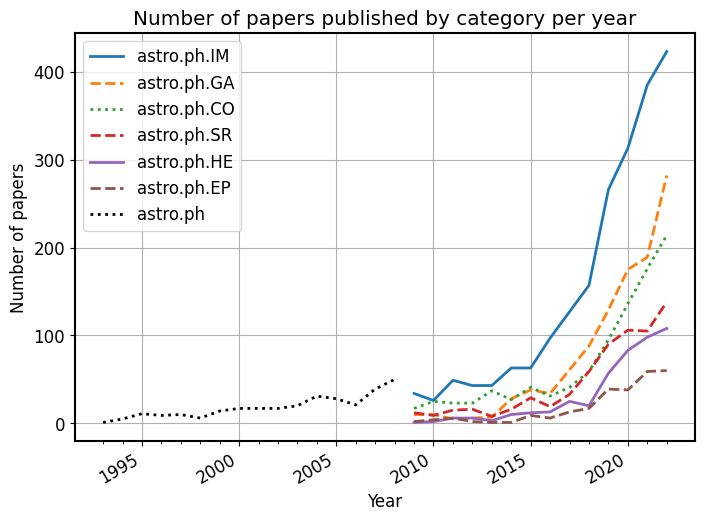

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(im_dict.keys(), im_dict.values(), label='astro.ph.IM', linewidth=2)
ax.plot(ga_dict.keys(), ga_dict.values(), label='astro.ph.GA', linewidth=2, linestyle='dashed')
ax.plot(co_dict.keys(), co_dict.values(), label='astro.ph.CO', linewidth=2, linestyle='dotted')
ax.plot(sr_dict.keys(), sr_dict.values(), label='astro.ph.SR', linewidth=2, linestyle='dashed')
ax.plot(he_dict.keys(), he_dict.values(), label='astro.ph.HE', linewidth=2)
ax.plot(ep_dict.keys(), ep_dict.values(), label='astro.ph.EP', linewidth=2, linestyle='dashed')
ax.plot(ph_dict.keys(), ph_dict.values(), label='astro.ph', linewidth=2, linestyle='dotted', color='black')

ax.set_xticks(years, minor=True)

plt.title('Number of papers published by category per year')
plt.xlabel('Year')
plt.ylabel('Number of papers')

plt.legend()
plt.grid()
fig.autofmt_xdate()

plt.savefig('hyp2-1.png')
plt.show()

###Hypothesis 3

####Preprocessing

Convert all arXiv ids into string and re-add leading zeroes that were removed.

In [9]:
ids = []

for index, row in svm_full_df.iterrows():
    if type(row['id']) == float:
        if (str(row['id']))[4] != '.':
            ids.append(str(0) + str(row['id']))
        else:
            ids.append(str(row['id']))
    elif type(row['id']) == str:
        ids.append(str(row['id']))

svm_full_df['id'] = ids

####Setting up the ads API

Install and import the Python ads API module.

In [4]:
!pip install ads
import ads

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ads: filename=ads-0.12.3-py3-none-any.whl size=37373 sha256=8dab4c61c2b268583fc7c3a054b8808dd33848c3b32d682e4635268844ea8417
  Stored in directory: /root/.cache/pip/wheels/f6/58/3a/89f967413ce40834546a8461de8b735d9f24c5f520802188d2
  Created wheel for httpretty: filename=httpretty-0.8.10-py3-none-any.whl size=23998 sha256=8d63f8d5c48d2aae7d3456b48e2782b9bffcfdabf88b9d17378bfb7938f109bb
  Stored in directory: /root/.cache/pip/wheels/fc/5d/09/2ab9bcf3f2bdd57a4be12cc5868c304ef1f4953292022ff9e7
Successfully built ads httpretty


Configure the ads API token.

In [5]:
ads.config.token = 'DwfLcfka8BjXmNvfiGqzyyqLiR3nK8D7E5ZbXplt'

This cell can be used to check rate limits and reset time. Ads has a rate limit of 5000 calls per day so it is likely that searches will have to be split into subsets and performed over multiple days.

In [6]:
q = (ads.SearchQuery(q='rate', fl=['citation_count']))
r = ads.RateLimits('SearchQuery')
q = ads.SearchQuery(q=q)
for paper in q:
    print(paper.title, paper.citation_count)
r.limits

{'limit': '5000', 'remaining': '306', 'reset': '1691935228'}

####Searching for ML papers

**The dataframe might be larger than the rate limit (5000), if so, it will need to be split into subsets and carried out over multiple days.**

Search for the paper title in ads and return the citation count, adding it to the dataframe.

In [28]:
query_res = []
for index, row in svm_full_df.iterrows():
    searchstr = 'arxiv:' + str(row['id'])
    try:
        q = list(ads.SearchQuery(q=searchstr, fl=['citation_count']))
        query_res.append(q[0].citation_count)
    except:
        query_res.append(None)

svm_full_df['citations'] = query_res

"\nquery_res = []\nfor index, row in svm_full_df.iterrows():\n    searchstr = 'arxiv:' + str(row['id'])\n    try:\n        q = ads.SearchQuery(q=searchstr, fl=['citation_count'])\n        for paper in q:\n            query_res.append(paper.citation_count)\n    except:\n        query_res.append(None)\n\nsvm_full_df['citations'] = query_res\n"

In [32]:
svm_full_df.to_csv('svm_full_df.csv')

Sort the citations and put into new dataframe.

In [33]:
citations_df = svm_full_df.sort_values(by=['citations'], ascending=False, inplace=False)
citations_df['cite_norm'] = citations_df['citations']/(2024-citations_df['year'])
citations_df.sort_values(by=['cite_norm'], ascending=False, inplace=True)
citations_df.to_csv('citations_df.csv')

####Non-ML papers

**The dataframe might be larger than the rate limit (5000), if so, it will need to be split into subsets and carried out over multiple days.**

Take a stratified sample of all papers and preprocess it for searching.

In [ ]:
stratified_sample, _ = train_test_split(papers_df, train_size=0.0151791154, stratify=papers_df[['year']])

ids = []

for index, row in stratified_sample.iterrows():
    if type(row['id']) == float:
        if (str(row['id']))[4] != '.':
            ids.append(str(0) + str(row['id']))
        else:
            ids.append(str(row['id']))
    elif type(row['id']) == str:
        ids.append(str(row['id']))

stratified_sample['id'] = ids

In [ ]:
stratified_sample.to_csv('stratified_sample.csv')

Search and save results.

In [ ]:
query_res = []
for index, row in stratified_sample.iterrows():
    searchstr = 'arxiv:' + str(row['id'])
    try:
        q = ads.SearchQuery(q=searchstr, fl=['citation_count'])
        for paper in q:
            query_res.append(paper.citation_count)
    except:
        query_res.append(None)

stratified_sample['citations'] = query_res

In [ ]:
stratified_sample.to_csv('stratified_sample.csv')

Sort the results.

In [ ]:
citations_nonml_df = stratified_sample.sort_values(by=['citations'], ascending=False, inplace=False)
citations_nonml_df['cite_norm'] = citations_nonml_df['citations']/(2024-citations_nonml_df['year'])
citations_nonml_df.sort_values(by=['cite_norm'], ascending=False, inplace=True)
citations_nonml_df.to_csv('citations_nonml_df.csv')

####Processing results

Plot the distribution of yearly citation count.

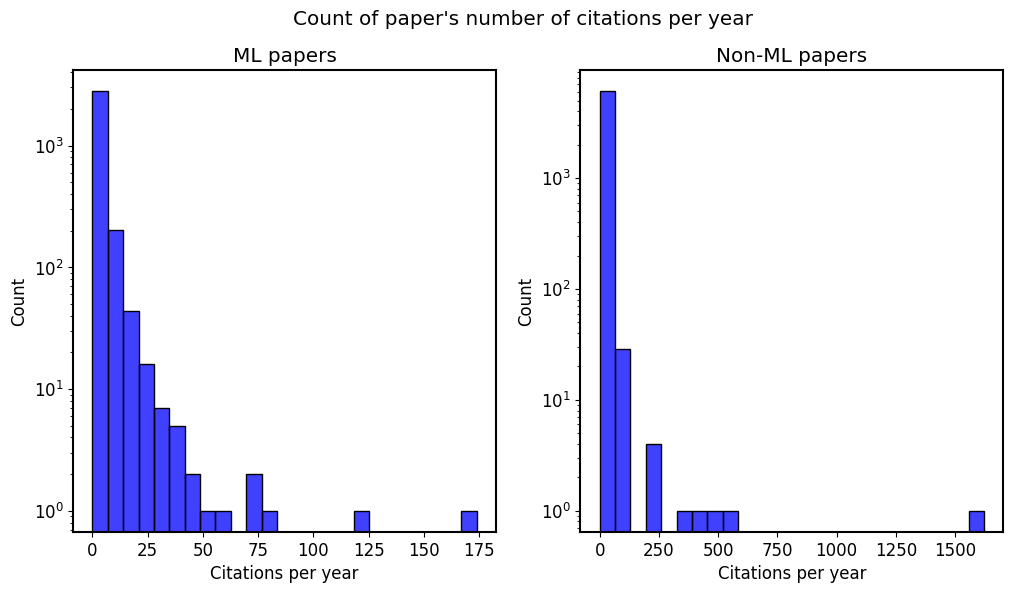

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].set_yscale('log', base=10)
sns.histplot(citations_df.cite_norm, bins=25, fill=True, stat='count', ax=ax[0], color='blue')
ax[0].set_title('ML papers')
ax[0].set_xlabel('Citations per year')

ax[1].set_yscale('log', base=10)
sns.histplot(citations_nonml_df.cite_norm, bins=25, fill=True, stat='count', ax=ax[1], color='blue')
ax[1].set_title('Non-ML papers')
ax[1].set_xlabel('Citations per year')

f.suptitle('Count of paper\'s number of citations per year')
plt.savefig('hyp4hist.png')

plt.show()

Take the top 10% of papers from ML and Non-ML dataframes.

In [ ]:
n = 10 #Percentage considered high impact
high_impact_df = citations_df.head(int(len(citations_df)*(n/100)))
low_impact_df = pd.concat([citations_df,high_impact_df]).drop_duplicates(keep=False, subset=['id'])
high_impact_nonml_df = citations_nonml_df.head(int(len(citations_nonml_df)*(n/100)))
low_impact_nonml_df = pd.concat([citations_nonml_df,high_impact_df]).drop_duplicates(keep=False, subset=['id'])

Get measures of the number of authors and add it to a dataframe to be viewed as a table.

In [ ]:
prominent = pd.DataFrame()
prominent['ML +'] = high_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])
prominent['ML -'] = low_impact_df['clean_authors'].str.len().agg(['mean','max','std','median'])
prominent['NML +'] = high_impact_nonml_df['clean_authors'].str.len().agg(['mean','max','std','median'])
prominent['NML -'] = low_impact_nonml_df['clean_authors'].str.len().agg(['mean','max','std','median'])
prominent=prominent.transpose()

In [ ]:
prominent

,mean,max,std,median
ML +,12.971717,389.0,36.361979,6.0
ML -,7.769886,494.0,21.166131,4.0
NML +,14.011250,1138.0,55.189569,4.0
NML -,7.551622,1547.0,29.722198,4.0


--------------------------------------------------------------------------------------------------------------------

###Hypothesis 4


NameError: ignored

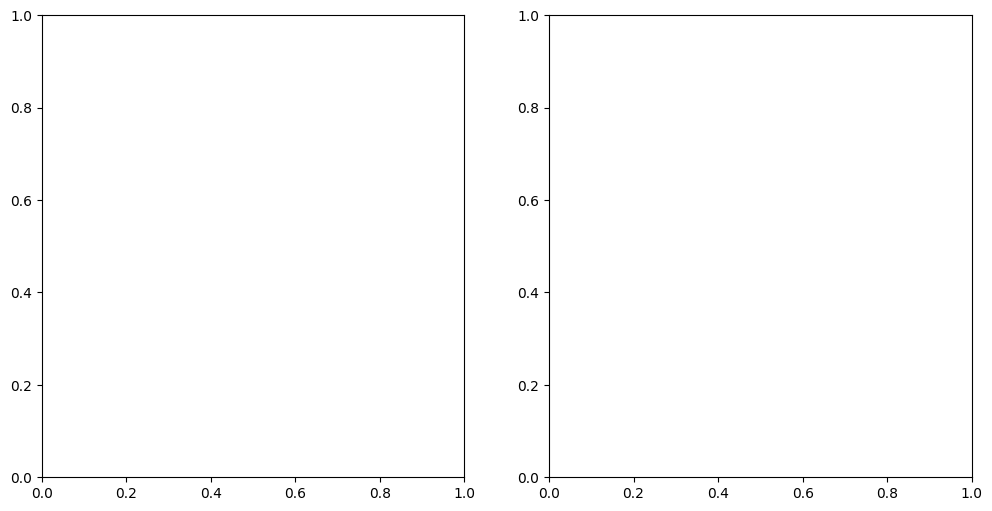

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))

axs[1].plot((svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave1'].year.value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'First wave', linewidth=2)
axs[1].plot((svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave2'].year.value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'Second wave', linewidth=2)
axs[1].plot((svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave3'].year.value_counts().sort_index()/papers_df['year'].value_counts().sort_index())*100, label = 'Third wave', linewidth=2)
axs[1].legend()
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Papers (%)')
axs[1].set_title('Percentage of total astrophysics papers')
axs[1].set_xticks(np.arange(1993, 2023, 5))
axs[1].xaxis.set_minor_locator(MultipleLocator(1))
axs[1].grid()

axs[0].plot(svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave1'].year.value_counts().sort_index(), label = 'First wave', linewidth=2)
axs[0].plot(svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave2'].year.value_counts().sort_index(), label = 'Second wave', linewidth=2)
axs[0].plot(svm_full_22_df.loc[svm_full_22_df['predicted'] == 'Wave3'].year.value_counts().sort_index(), label = 'Third wave', linewidth=2)
axs[0].legend()
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total Papers')
axs[0].set_title('Absolute numbers')
axs[0].set_xticks(np.arange(1993, 2023, 5))
axs[0].xaxis.set_minor_locator(MultipleLocator(1))
axs[0].grid()

fig.autofmt_xdate()
fig.suptitle('Papers of each wave published annually')

plt.savefig("hyp4.png")
plt.show()